In [2]:
from sklearn.datasets import fetch_mldata
mnist=fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X,y=mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


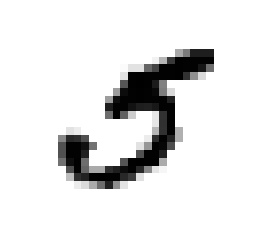

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_image = X[36000].reshape(28, 28)
plt.imshow(some_digit_image, interpolation='nearest', cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()

In [5]:
import numpy as np

shuffle_index=np.random.permutation(60000)
X_train, X_test, y_train, y_test=X[:60000][shuffle_index], X[60000:], y[:60000][shuffle_index], y[60000:] 

In [6]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [8]:
#Measuring accuracy using cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_folds=X_train[test_index]
    y_test_folds=y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    pred=clone_clf.predict(X_test_folds)
    accuracy=sum(pred==y_test_folds)/len(y_test_folds)
    print(accuracy)

0.96095
0.95575
0.95645


In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.96095,  0.95575,  0.95645])

### Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

In [10]:
# Confusion Matrix
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53992,   587],
       [ 1950,  3471]])

In [12]:
# Precision of the classifier: Accuracy of the positive predictions
# Precision = TP/(TP + FP)
# Recall or Sensitivity or True Positive Rate: Ratio of positive instances that are correctly detected by the classifier
# Recall = TP/(TP + FN)
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
recall_score(y_train_5, y_train_pred)

0.855347461804


0.64028776978417268

In [13]:
# The F1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.73235573372718654

In [14]:
# Precision/Recall Tradeoff
# Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa.
# This is called the precision/recall tradeoff.
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [15]:
y_scores[52000]

array([      0.        , -492634.64027617])

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores[:,1])

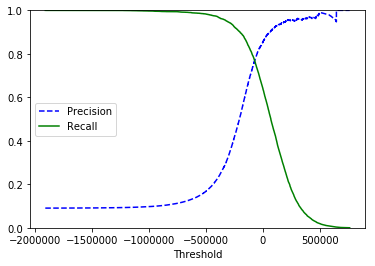

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [18]:
# The ROC(Receiver Operating Characteristic) Curve
# In ROC, we plot TPR(Recall) and FPR = (FP/(FP + TN)) = 1 - specificity(TNR)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5, y_scores[:,1])

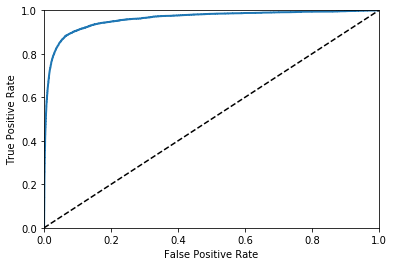

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [20]:
# ROC AUC(Area Under the Curve)
# For a good estimator, AUC must equal 1, and must stay as away from dotted line as possible  
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores[:,1])

0.9607014040789067

### As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [22]:
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_probas_forest[:,1])

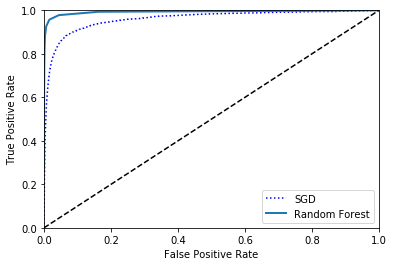

In [23]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
roc_auc_score(y_train_5, y_probas_forest[:,1])

0.99321027050009691

In [27]:
y_pred_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_pred_forest)

0.98383167220376522

In [28]:
recall_score(y_train_5, y_pred_forest)

0.81940601365061794

##### Random Forest and Naive Bayes classifiers are capable of handling multiple classes directly and hence they print probabilies for each class. SGD and SVM are binary classifiers and thus in general use OvA and OvO.
##### Some classifiers such as SVM scale poorly with the size of the training set, thus OvO binary classification is better for them. 

In [29]:
cross_val_score(sgd_clf, X_train, y_train, cv=3)

array([ 0.84258148,  0.83849192,  0.88023203])

In [30]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)

array([ 0.90746851,  0.90929546,  0.9113367 ])

In [34]:
# Error Analysis
cross_val_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_matrix=confusion_matrix(y_train, cross_val_pred)

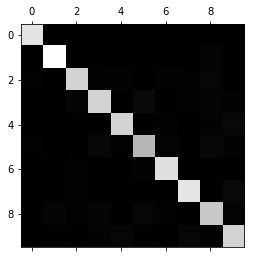

In [35]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

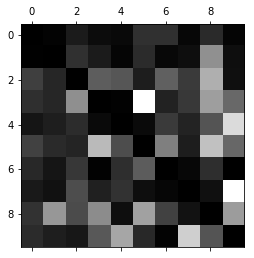

In [36]:
row_sums=conf_matrix.sum(axis=1, keepdims=True)
conf_normal_matrix=conf_matrix/row_sums
np.fill_diagonal(conf_matrix, 0)
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


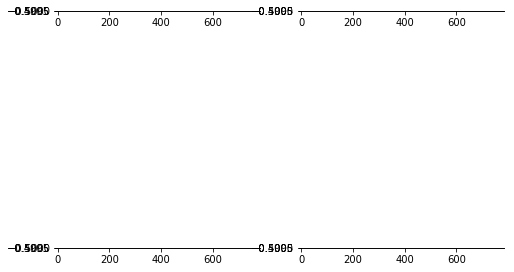

In [39]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))

plt.subplot(221); plt.imshow(X_aa[:25])
plt.subplot(222); plt.imshow(X_ab[:25])
plt.subplot(223); plt.imshow(X_ba[:25])
plt.subplot(224); plt.imshow(X_bb[:25])
plt.show()

In [40]:
# Multilabel Classification
# KNearestNeighbor is generally used for MultiLablClassification

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
param_grid=[{'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}]
grid_search=GridSearchCV(knn, param_grid, verbose=1, n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [46]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
from scipy.ndimage.interpolation import shift

X_train_trans_np=X_train_scaled.as_matrix().reshape(-1, 28, 28)
X_train_shift_1=X_train_trans_np.shift(shift=[0, 1, 0])
X_train_shift_2=X_train_trans_np.shift(shift=[0, -1, 0])
X_train_shift_3=X_train_trans_np.shift(shift=[0, 0, 1])
X_train_shift_4=X_train_trans_np.shift(shift=[0, 0, -1])
X_train_big=
np.concatenate(X_train_scaled.as_matrxi(), X_train_shift_1, X_train_shift_2, X_train_shift_3, X_train_shift_4)